In [1]:
import sys
sys.path.append('../../')

from denn.rk4 import rk4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.integrate import solve_ivp

In [2]:
# load in the DEQGAN solutions

# NLO
nlo1 = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/NLO_run/pred_dict1.npy', allow_pickle=True)[()]
nlo2 = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/NLO_run/pred_dict2.npy', allow_pickle=True)[()]
nlo3 = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/NLO_run/pred_dict3.npy', allow_pickle=True)[()]

# COO
coo = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/COO_run/pred_dict.npy', allow_pickle=True)[()]

# BURV
burv = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/BURV_run/pred_dict.npy', allow_pickle=True)[()]
burv_grid = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/BURV_run/grid.npy', allow_pickle=True)[()]

# ACA
aca = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/ACA_run/pred_dict.npy', allow_pickle=True)[()]
aca_grid = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/runs/ACA_run/grid.npy', allow_pickle=True)[()]

In [3]:
def nlo_deriv(t, xz):
    """ 
    $$ \ddot{x} + 2 \beta \dot{x} + \omega^{2} x + \phi x^{2} + \epsilon x^{3} = f(t) $$
    dxdt = z
    dzdt = -2 beta z - omega^2 x - phi x^2 - eps x^3
    
    x0 = 0
    self.omega = 1
    self.epsilon = .1
    self.beta = .1
    self.phi = 1
    
    n: 400
    t_max: 12.56
    dx_dt0: 0.5
    """
    b = 0.1
    e = 0.1
    o = 1
    p = 1
    
    x = xz[0]
    z = xz[1]
    rhs = np.array([z, -2*b*z - o*o*x - p*x*x - e*(x**3)])
    return rhs

def _nlo_system(t, z):
    omega = 1
    epsilon = .1
    beta = .1
    phi = 1    
    x, y = z
    return np.array([y, -(2 * beta * y + (omega**2) * x + phi * (x**2) + epsilon * (x**3))])

def nlo_scipy(t_span=[0, 12.56], y0=[0, 0.5]):
    atol = 1e-8
    rtol = 1e-8
    sol = solve_ivp(
        _nlo_system,
        t_span=t_span,
        y0=y0,
        dense_output=True,
        atol=atol,
        rtol=rtol,
    )
    return sol

In [4]:
# get the numerical solutions

# NLO
ics = [0.5, 0.6, 0.7]
x_hat_sols = []
x_dot_sols = []
for i in range(3):
    nlo_sol = nlo_scipy([0, 12.56], [0, ics[i]])
    x_hat_sol = nlo_sol.y[0]
    x_dot_sol = nlo_deriv(nlo_sol.t, np.squeeze(nlo_sol.y))[0]
    x_hat_sols.append(x_hat_sol)
    x_dot_sols.append(x_dot_sol)

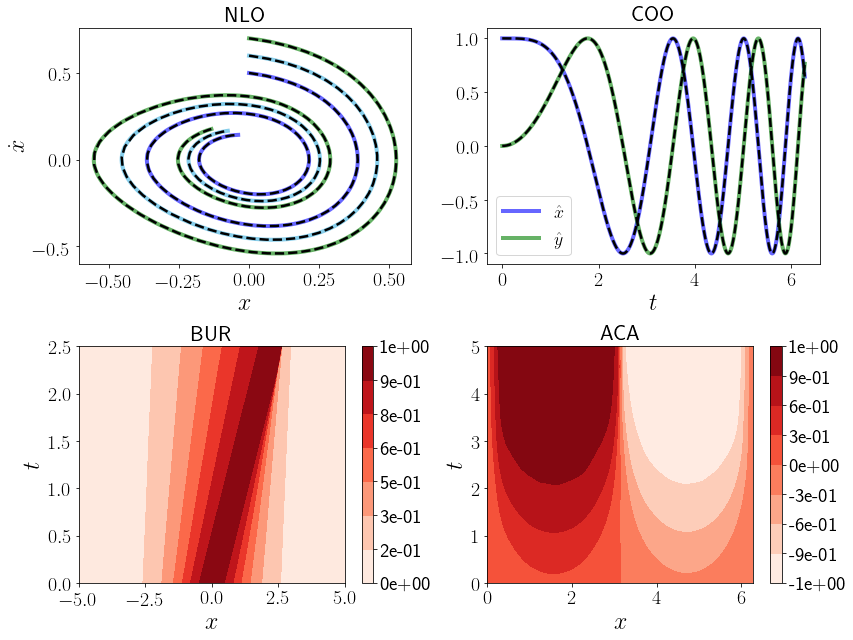

In [5]:
plt.rc('axes', titlesize=22, labelsize=24)
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(2, 2, figsize=(12,9))
ax = ax.ravel()

# NLO
x_hats = [nlo1["$\\hat{x}$"], nlo2["$\\hat{x}$"], nlo3["$\\hat{x}$"]]
x_dots = [nlo1["$\\dot{x}$"], nlo2["$\\dot{x}$"], nlo3["$\\dot{x}$"]]
c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])
colors = ["blue", "skyblue", "green"]
alphas = [0.6, 1.0, 0.6]
for i in range(3):
    ax[0].plot(x_hats[i], x_dots[i], linewidth=4, color=colors[i], alpha=alphas[i]) # cmap.to_rgba(i+2)
    ax[0].plot(x_hat_sols[i], x_dot_sols[i], linewidth=2.5, color="black", linestyle="--")
    if i == 0:
        ax[0].set_title("NLO")
        ax[0].set_xlabel("$x$")
        ax[0].set_ylabel("$\dot{x}$")
# ax[0].legend()

# COO
t = np.linspace(0, 6.28, len(coo['$\\hat{x}$']))
xsol = np.cos((t**2) / 2)
ysol = np.sin((t**2) / 2)
ax[1].plot(t, coo['$\\hat{x}$'], label="$\hat{x}$", linewidth=4, color="blue", alpha=0.6)
ax[1].plot(t, coo['$\\hat{y}$'], label="$\hat{y}$", linewidth=4, color="green", alpha=0.6)
ax[1].plot(t, xsol, linewidth=2.5, color="black", linestyle="--")
ax[1].plot(t, ysol, linewidth=2.5, color="black", linestyle="--")
ax[1].set_title("COO")
ax[1].set_xlabel("$t$")
ax[1].legend()

# BUR
x, y = burv_grid[:, 0], burv_grid[:, 1]
xdim, ydim = 1000, 100
xx, yy = x.reshape((xdim, ydim)), y.reshape((xdim, ydim))
sol = burv['$\\hat{u}$'].reshape((xdim, ydim))
cf = ax[2].contourf(xx, yy, sol, cmap="Reds")
cb = fig.colorbar(cf, format='%.0e', ax=ax[2])
ax[2].set_title("BUR")
ax[2].set_xlabel("$x$")
ax[2].set_ylabel("$t$")

# ACA
x, y = aca_grid[:, 0], aca_grid[:, 1]
xdim, ydim = 1000, 100
xx, yy = x.reshape((xdim, ydim)), y.reshape((xdim, ydim))
sol = aca['$\\hat{u}$'].reshape((xdim, ydim))
cf = ax[3].contourf(xx, yy, sol, cmap="Reds")
cb = fig.colorbar(cf, format='%.0e', ax=ax[3])
ax[3].set_title("ACA")
ax[3].set_xlabel("$x$")
ax[3].set_ylabel("$t$")

plt.tight_layout()
# plt.savefig("example_solutions.png", dpi=300)

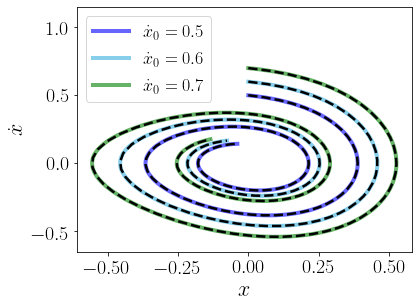

In [12]:
plt.rc('axes', titlesize=20, labelsize=22)
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(6,4.5))

# NLO
x_hats = [nlo1["$\\hat{x}$"], nlo2["$\\hat{x}$"], nlo3["$\\hat{x}$"]]
x_dots = [nlo1["$\\dot{x}$"], nlo2["$\\dot{x}$"], nlo3["$\\dot{x}$"]]
colors = ["blue", "skyblue", "green"]
alphas = [0.6, 1.0, 0.6]
labels = ["$\dot{x}_0 = 0.5$","$\dot{x}_0 = 0.6$","$\dot{x}_0 = 0.7$"]
for i in range(3):
    ax.plot(x_hats[i], x_dots[i], linewidth=4, color=colors[i], alpha=alphas[i], label=labels[i])
    ax.plot(x_hat_sols[i], x_dot_sols[i], linewidth=2.5, color="black", linestyle="--")
    if i == 0:
        ax.set_xlabel("$x$")
        ax.set_ylabel("$\dot{x}$")
ax.set_ylim(-0.65, 1.15)
ax.legend()
# plt.show()
plt.savefig("nlo_solution.png", bbox_inches='tight', dpi=300)

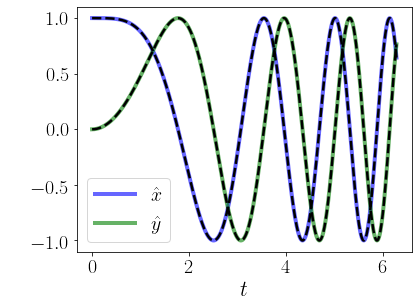

In [19]:
plt.rc('axes', titlesize=20, labelsize=22)
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(6,4.5))

# COO
t = np.linspace(0, 6.28, len(coo['$\\hat{x}$']))
xsol = np.cos((t**2) / 2)
ysol = np.sin((t**2) / 2)
ax.plot(t, coo['$\\hat{x}$'], label="$\hat{x}$", linewidth=4, color="blue", alpha=0.6)
ax.plot(t, coo['$\\hat{y}$'], label="$\hat{y}$", linewidth=4, color="green", alpha=0.6)
ax.plot(t, xsol, linewidth=2.5, color="black", linestyle="--")
ax.plot(t, ysol, linewidth=2.5, color="black", linestyle="--")
ax.set_xlabel("$t$")
ax.set_ylabel("$\dot{x}$", color="white")
ax.legend()
# plt.show()
plt.savefig("coo_solution.png", bbox_inches='tight', dpi=300)

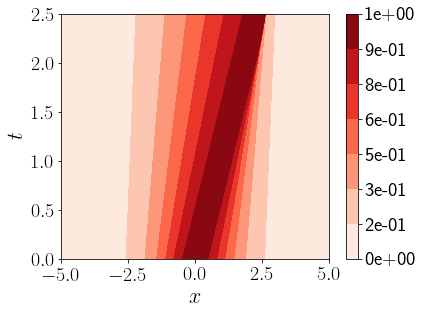

In [15]:
plt.rc('axes', titlesize=20, labelsize=22)
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(6,4.5))

# BUR
x, y = burv_grid[:, 0], burv_grid[:, 1]
xdim, ydim = 1000, 100
xx, yy = x.reshape((xdim, ydim)), y.reshape((xdim, ydim))
sol = burv['$\\hat{u}$'].reshape((xdim, ydim))
cf = ax.contourf(xx, yy, sol, cmap="Reds")
cb = fig.colorbar(cf, format='%.0e', ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
plt.show()
# plt.savefig("bur_solution.png", bbox_inches='tight', dpi=300)

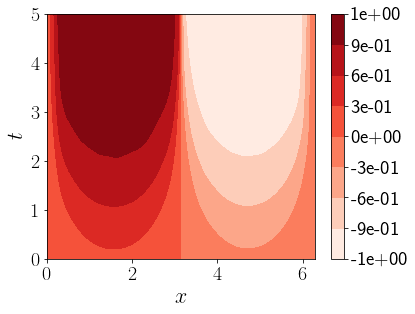

In [16]:
plt.rc('axes', titlesize=20, labelsize=22)
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(6,4.5))

# ACA
x, y = aca_grid[:, 0], aca_grid[:, 1]
xdim, ydim = 1000, 100
xx, yy = x.reshape((xdim, ydim)), y.reshape((xdim, ydim))
sol = aca['$\\hat{u}$'].reshape((xdim, ydim))
cf = ax.contourf(xx, yy, sol, cmap="Reds")
cb = fig.colorbar(cf, format='%.0e', ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
# plt.show()
plt.savefig("aca_solution.png", bbox_inches='tight', dpi=300)